# Importing Libraries

In [102]:
import json
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopy
from geopy.distance import vincenty 
from matplotlib.collections import PatchCollection
from IPython.display import Image
warnings.filterwarnings('ignore')

# Importing the JSON file

In [103]:
with open('C:/Users/User/Desktop/LocationHistory.json', 'r') as fh:
    data = json.loads(fh.read())
data = data['locations']

# Data-Preprocessing

In [104]:
def get_normalized_activities(activities):
    data = list()
    for activity in activities:
        temp = list()
        for act in activity['activity']:
            temp.append(act)
        total = sum([value['confidence'] for value in temp])
        temp = [{'type':value['type'],'confidence':value['confidence']/total} for value in temp]
        data += temp
    return data

def get_date(time):
    day = time.day
    hour = time.hour

    day_of_week = time.weekday()
    day_of_week_index = [0,1,2,3,4,5,6]
    day_of_week_name = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
    index = day_of_week_index.index(day_of_week)
    day_of_week = day_of_week_name[index]

    year = time.year

    month = time.month
    month_index = [1,2,3,4,5,6,7,8,9,10,11,12]
    month_name = ['Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']
    index = month_index.index(month)
    month = month_name[index]
    
    return {'day':day, 'hour':hour,'day_of_week':day_of_week, 'month':month, 'year':year}

def remove_wrong_data(data):
    degrees_to_radians = np.pi/180.0
    data_new = list()
    for index in range(len(data)):
        longitude = data[index]['longitudeE7']/float(1e7)
        if longitude > 101.77 and longitude < 101.8:
            data_new.append(data[index])
    return data_new

def get_data(data):
    data = remove_wrong_data(data)
    data = sorted(data,key = lambda x: x['timestampMs'])
    for index in range(len(data)):
        data[index]['latitudeE7']  = data[index]['latitudeE7']/float(1e7)
        data[index]['longitudeE7'] = data[index]['longitudeE7']/float(1e7)
        data[index]['timestampMs'] = float(data[index]['timestampMs'])/1000
        data[index]['datetime'] = datetime.datetime.fromtimestamp(data[index]['timestampMs'])
        dates = get_date(data[index]['datetime'])
        data[index]['day'] = dates['day']
        data[index]['day_of_week'] = dates['day_of_week']
        data[index]['month'] = dates['month']
        data[index]['year'] = dates['year']
        data[index]['hour'] = dates['hour']
        if 'activity' in data[index].keys():
            data[index]['activity'] = get_normalized_activities(data[index]['activity'])
        if index != 0:
            lat1 = data[index-1]['latitudeE7']
            lat2 = data[index]['latitudeE7']
            long1 = data[index-1]['longitudeE7']
            long2 = data[index]['longitudeE7']
            coords_1 = (lat1,long2)
            coords_2 = (lat2,long2)
            data[index]['distance'] = vincenty(coords_1,coords_2).km
    del data[0]
    return data

def get_new_data(data):
    data_new = list()
    for dictionary in data:
        if 'activity' in dictionary.keys() and dictionary['accuracy'] > 0 and dictionary['accuracy'] < 1000:
            for activity in dictionary['activity']:
                data_new.append({
                    'latitude':dictionary['latitudeE7'],
                    'longitude':dictionary['longitudeE7'],
                    'accuracy':dictionary['accuracy'],
                    'type':activity['type'],
                    'confidence':activity['confidence'],
                    'day':dictionary['day'],
                    'hour':dictionary['hour'],
                    'day_of_week':dictionary['day_of_week'],
                    'month':dictionary['month'],
                    'year':dictionary['year'],
                    'distance':dictionary['distance'],
                    'normalized_distance':dictionary['distance'] * activity['confidence']
                })
    return data_new

city = {
    'fst':{
        'latitude':2.922,
        'longitude':101.78
    },
    'kkm':{
        'latitude':2.927,
        'longitude':101.79
    },
    'ptsl':{
        'latitude':2.926,
        'longitude':101.78
    },
    
}
def get_city(latitude):
    latitude = int(latitude)
    if latitude < 3:
        return 'FST'
   
    else:
        return 'Other'


In [105]:
data = get_data(data)
data = get_new_data(data)
data = pd.DataFrame(data)
data = data[data.distance.notnull()]
data['city'] = data.latitude.apply(lambda x: get_city(x))


Let's pickle the file so that we can start directly without re-running the pre-processing steps every time we run the Jupyter Notebook

In [106]:
import pickle
pickle_out = open("data.sav","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [107]:
import pickle
pickle_in = open("data.sav","rb")
data = pickle.load(pickle_in)

In [108]:
data.sample(10).reset_index(drop = True)

,accuracy,confidence,day,day_of_week,distance,hour,latitude,longitude,month,normalized_distance,type,year,city
0,26,1.000000,31,Fri,0.000000,12,2.926829,101.789103,March,0.000000,STILL,2017,FST
1,23,0.770000,4,Tues,0.030708,19,3.424959,101.795257,July,0.023645,STILL,2017,Other
2,26,1.000000,31,Fri,0.025588,12,2.926829,101.789103,March,0.025588,TILTING,2017,FST
3,300,0.510000,4,Tues,0.069366,18,3.423978,101.795646,July,0.035377,IN_VEHICLE,2017,Other
4,24,0.150000,31,Fri,0.051286,12,2.926828,101.789192,March,0.007693,IN_VEHICLE,2017,FST
5,500,0.032432,24,Sun,0.618956,9,2.929095,101.788168,Dec,0.020074,STILL,2017,FST
6,22,0.070968,5,Wed,0.018080,9,3.424151,101.794967,July,0.001283,IN_VEHICLE,2017,Other
7,500,1.000000,24,Sun,0.618956,9,2.929095,101.788168,Dec,0.618956,TILTING,2017,FST
8,60,0.005181,20,Tues,0.418645,13,2.857369,101.787543,Feb,0.002169,IN_ROAD_VEHICLE,2018,FST
9,300,0.074766,4,Tues,0.340935,18,3.423978,101.795646,July,0.025490,UNKNOWN,2017,Other


In [109]:
data.describe()

,accuracy,confidence,day,distance,hour,latitude,longitude,normalized_distance,year
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,168.569468,0.313894,16.543739,0.530332,13.526587,3.087950,101.789987,0.215593,2016.869640
std,272.537752,0.326777,11.010042,1.699708,4.281611,0.244500,0.004834,1.063960,0.483566
min,3.000000,0.005076,3.000000,0.000000,8.000000,2.820991,101.772367,0.000000,2016.000000
25%,23.000000,0.056738,4.000000,0.007105,10.000000,2.926561,101.787481,0.000965,2017.000000
50%,30.000000,0.180000,20.000000,0.037276,12.000000,2.929095,101.789232,0.005805,2017.000000
75%,110.000000,0.470232,28.000000,0.175265,18.000000,3.424141,101.794940,0.031973,2017.000000
max,980.000000,1.000000,31.000000,12.075458,23.000000,3.425644,101.799323,8.263118,2018.000000


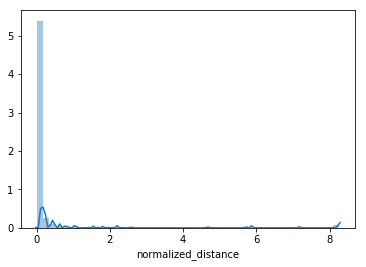

In [110]:
sns.distplot(data.normalized_distance)
plt.savefig('fig_normalized_distance.png', dpi = 300)
plt.show()

In [111]:
values = data.normalized_distance.values
blocks = ['0_0.01','0.001-0.1','0.1-0.5','0.5-1','1-2','2-5','5-10','10-20','20-50','50-100','100+']
block_values = [0,0,0,0,0,0,0,0,0,0,0]

for value in values:
    if value > 0 and value < 0.01:
        block_values[0] += 1
    if value > 0 and value < 0.1:
        block_values[1] += 1
    if value > 0.1 and value < 0.5:
        block_values[2] += 1
    elif value > 0.5 and value < 1:
        block_values[3] += 1
    elif value > 1 and value < 2:
        block_values[4] += 1
    elif value > 2 and value < 5:
        block_values[5] += 1
    elif value > 5 and value < 10:
        block_values[6] += 1
    elif value > 10 and value < 20:
        block_values[7] += 1
    elif value > 20 and value < 50:
        block_values[8] += 1
    elif value > 50 and value < 100:
        block_values[9] += 1
    elif value > 100:
        block_values[10] += 1

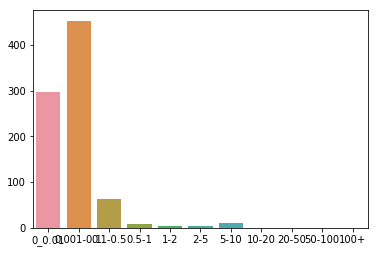

In [112]:
sns.barplot(x = blocks,y = block_values)
plt.savefig('fig_bar_chart.png', dpi = 300)
plt.show()

In [113]:
data_low = data[data.normalized_distance < 1]
data_large = data[data.normalized_distance > 1]

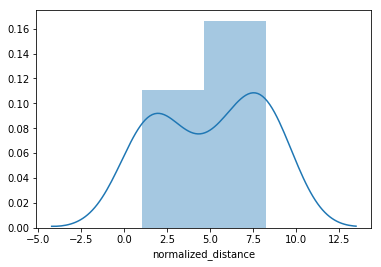

In [114]:
sns.distplot(data_large.normalized_distance)
plt.show()

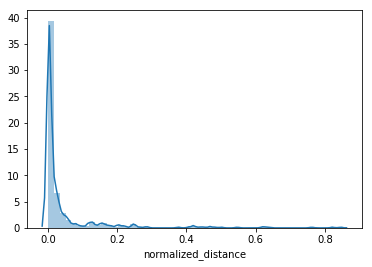

In [115]:
sns.distplot(data_low.normalized_distance)
plt.show()

# Geography

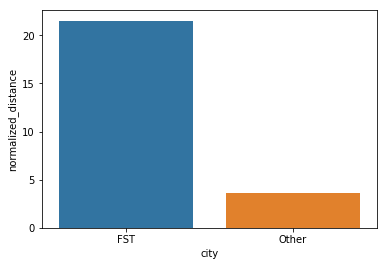

In [116]:
temp = data_low[['city','normalized_distance']]
temp = temp.groupby(['city']).sum().reset_index()
sns.barplot(x="city", y="normalized_distance",data=temp)
plt.savefig('city_wise_distance.png', dpi = 300)
plt.show()

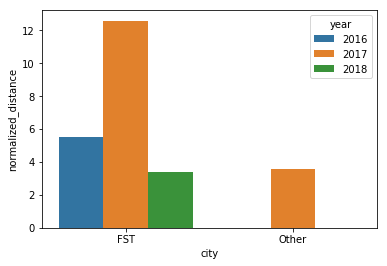

In [117]:
temp = data_low[['city','year','normalized_distance']]
temp = temp.groupby(['city','year']).sum().reset_index()
sns.barplot(x="city", y="normalized_distance",hue='year',data=temp)
plt.savefig('city_year_wise_distance.png', dpi = 300)
plt.show()

# Day of week vs distance normalized

In [118]:
data_low.sample(5)

,accuracy,confidence,day,day_of_week,distance,hour,latitude,longitude,month,normalized_distance,type,year,city
167,22,0.330000,31,Fri,0.034146,12,2.927138,101.788836,March,0.011268,IN_VEHICLE,2017,FST
70,79,0.038095,28,Sun,0.054537,10,2.930341,101.786686,Aug,0.002078,ON_FOOT,2016,FST
303,24,0.118812,4,Tues,0.012130,19,3.425197,101.794767,July,0.001441,UNKNOWN,2017,Other
146,39,0.400000,31,Fri,0.004169,12,2.926559,101.789325,March,0.001668,UNKNOWN,2017,FST
521,699,0.037594,24,Sun,0.099000,9,2.924283,101.780334,Dec,0.003722,WALKING,2017,FST


In [119]:
temp = data_low[['day_of_week','normalized_distance','year']].groupby(['day_of_week','year']).sum().reset_index()
index = [5,1,6,7,4,2,3]
indexes = list()
for i in range(len(index)):
    for j in range(6):
        indexes.append(index[i])
temp.index = indexes
temp.sort_index(inplace=True)
sns.barplot(x="day_of_week", y="normalized_distance",hue='year',data=temp)
plt.savefig('fig2.png', dpi = 300)
plt.show()

ValueError: Length mismatch: Expected axis has 9 elements, new values have 42 elements

# Year vs Distance Normalized

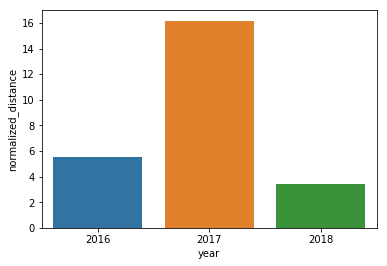

In [120]:
temp = data_low[['year','normalized_distance']].groupby(['year']).sum().reset_index()
sns.barplot(x="year", y="normalized_distance",data=temp)
plt.show()

# Year vs Distance Normalized

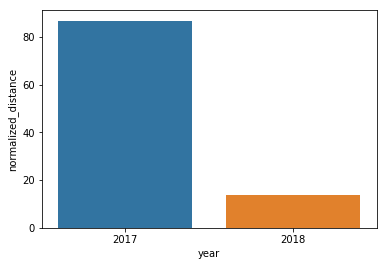

In [121]:
temp = data_large[['year','normalized_distance']].groupby(['year']).sum().reset_index()
data_large.sort_values(by = ['normalized_distance'],ascending=False)
sns.barplot(x="year", y="normalized_distance",data=temp)
plt.show()

# Type vs Distance Normalized

In [122]:
mapping_function = {
    'TILTING':'others',
    'STILL':'others',
    'UNKNOWN':'others',
    'IN_VEHICLE':'vehicle',
    'IN_ROAD_VEHICLE':'vehicle',
    'IN_RAIL_VEHICLE':'vehicle',
    'IN_FOUR_WHEELER_VEHICLE':'vehicle',
    'EXITING_VEHICLE':'vehicle',
    'IN_TWO_WHEELER_VEHICLE':'vehicle',
    'ON_FOOT':'walk',
    'WALKING':'walk',
    'ON_BICYCLE':'walk',
    'RUNNING':'walk',
}
def travel_pattern(city_name):
    temp = data_low[data_low.city == city_name]
    temp = temp[['day_of_week','type','normalized_distance']]
    temp.type = temp.type.map(mapping_function)
    temp = temp.groupby(['day_of_week','type']).sum().reset_index(drop = False)
    temp = temp[temp.type.isin(['vehicle','walk'])]
    temp.index = [5,5,1,1,6,6,7,7,4,4,2,2,3,3]
    temp = temp.sort_index().reset_index(drop = True)
    sns.barplot(x='day_of_week', y='normalized_distance',hue='type',data = temp)
    plt.title('Travel Pattern in ' + city_name)
    plt.savefig(city_name + '.png', dpi = 300)
    plt.show()
    return 

In [123]:
travel_pattern('FST')

ValueError: Length mismatch: Expected axis has 12 elements, new values have 14 elements

# Bangalore

In [ ]:
temp = data_low[data_low.city == 'Bangalore']
temp = temp[temp.year == 2018]
temp = temp[temp.month != 'Jan']
temp.type = temp.type.map(mapping_function)
temp = temp[['month','normalized_distance','type']]
temp = temp.groupby(['month','type']).sum().reset_index(drop = False)
temp = temp[temp.type != 'others']
index = [8,7,6,11,10,9]
indexes = list()
for i in range(len(index)):
    for j in range(2):
        indexes.append(index[i])
temp.index = indexes
temp.sort_index(inplace = True)
sns.barplot(x="month", y="normalized_distance",hue='type',data=temp)
plt.title('Travel patterns in Bangalore')
plt.savefig('Travel patterns in Bangalore.png', dpi = 300)
plt.show()

# Trivandrum

In [ ]:
temp = data_low[data_low.city == 'Trivandrum']
temp = temp[temp.year == 2018]
temp.type = temp.type.map(mapping_function)
temp = temp[['month','normalized_distance','type']]
temp = temp.groupby(['month','type']).sum().reset_index(drop = False)
temp = temp[temp.type != 'others']
index = [4,2,1,6,3,5]
indexes = list()
for i in range(len(index)):
    for j in range(2):
        indexes.append(index[i])
temp.index = indexes
temp.sort_index(inplace = True)
sns.barplot(x="month", y="normalized_distance",hue='type',data=temp)
plt.title('Travel patterns in Trivandrum')
plt.savefig('Travel patterns in Trivandrum.png', dpi = 300)
plt.show()

# Bangalore vs Trivandrum

In [ ]:
def day_type_mapping(day):
    if day in ['Sat','Sun']:
        return 'Weekend'
    return 'Weekday'

In [ ]:
temp = data_low[data_low.city.isin(['Bangalore','Trivandrum'])]
temp = temp[['day_of_week','type','normalized_distance','city']]
temp.type = temp.type.map(mapping_function)
temp = temp[temp.type == 'walk']
temp = temp[['day_of_week','normalized_distance','city']]
temp = temp.groupby(['day_of_week','city']).sum().reset_index()
mean_bangalore = temp['normalized_distance'][temp.city == 'Bangalore'].sum()
mean_trivandrum = temp['normalized_distance'][temp.city == 'Trivandrum'].sum()
temp['normalized_distance'][temp.city == 'Bangalore'] = temp['normalized_distance'] / mean_bangalore
temp['normalized_distance'][temp.city == 'Trivandrum'] = temp['normalized_distance'] / mean_trivandrum
temp.sort_values(by = ['day_of_week'],inplace = True)
temp.index = [5,5,1,1,6,6,7,7,4,4,2,2,3,3]
temp.sort_index(inplace = True)
sns.barplot(x="day_of_week", y="normalized_distance",hue='city',data=temp)
plt.title('Walk pattern')
plt.savefig('Walk.png', dpi = 300)
plt.show()

In [ ]:
temp = data_low[data_low.city.isin(['Bangalore','Trivandrum'])]
temp = temp[['day_of_week','type','normalized_distance','city']]
temp.type = temp.type.map(mapping_function)
temp = temp[temp.type == 'vehicle']
temp = temp[['day_of_week','normalized_distance','city']]
temp = temp.groupby(['day_of_week','city']).sum().reset_index()
mean_bangalore = temp['normalized_distance'][temp.city == 'Bangalore'].sum()
mean_trivandrum = temp['normalized_distance'][temp.city == 'Trivandrum'].sum()
temp['normalized_distance'][temp.city == 'Bangalore'] = temp['normalized_distance'] / mean_bangalore
temp['normalized_distance'][temp.city == 'Trivandrum'] = temp['normalized_distance'] / mean_trivandrum
temp.sort_values(by = ['day_of_week'],inplace = True)
temp.index = [5,5,1,1,6,6,7,7,4,4,2,2,3,3]
temp.sort_index(inplace = True)
sns.barplot(x="day_of_week", y="normalized_distance",hue='city',data=temp)
plt.title('Vehicle pattern')
plt.savefig('Vehicle.png', dpi = 300)
plt.show()

# type vs Hour

In [97]:
def get_time_blocks(time):
    if time < 5:
        return '0-5'
    elif time > 5 and time < 7:
        return '5-7'
    elif time > 7 and time < 10:
        return '7-10'
    elif time > 10 and time < 16:
        return '10-16'
    elif time > 16 and time < 20:
        return '16-20'
    else:
        return '20-24'

In [98]:
def time_vs_hour(city):
    temp = data_low[data_low.city == city]
    temp = temp[['hour','type','normalized_distance']]
    temp.type = temp.type.map(mapping_function)
    temp.hour = temp.hour.apply(lambda x: get_time_blocks(x))
    temp = temp.groupby(['hour','type']).sum().reset_index(drop = False)
    temp = temp[temp.type != 'others']
    temp.index = [1,1,4,4,5,5,6,6,2,2,3,3]
    temp.sort_index(inplace = True)
    temp = temp[temp.type != 'others']
    sns.barplot(x="hour", y="normalized_distance",hue='type',data=temp)
    plt.title(city + ' travel pattern')
    plt.savefig(city + '_travel_pattern.png', dpi = 300)
    plt.show()

In [99]:
time_vs_hour('FST')

ValueError: Length mismatch: Expected axis has 8 elements, new values have 12 elements

In [ ]:
time_vs_hour('Trivandrum')

In [ ]:
def city_vs_hour(typ,title):
    temp = data_low[data_low.city.isin(['Bangalore','Trivandrum'])]
    temp.type = temp.type.map(mapping_function)
    temp = temp[temp.type == typ]
    temp = temp[['hour','city','normalized_distance']]
    temp.hour = temp.hour.apply(lambda x: get_time_blocks(x))
    temp = temp.groupby(['hour','city']).sum().reset_index(drop = False)
    temp.index = [1,1,4,4,5,5,6,6,2,2,3,3]
    temp.sort_index(inplace = True)
    sns.barplot(x="hour", y="normalized_distance",hue='city',data=temp)
    plt.title(title)
    plt.savefig(title +'.png', dpi = 300)
    plt.show()

In [ ]:
city_vs_hour('vehicle',title = 'Vehicle Usage Pattern')

In [ ]:
city_vs_hour('walk',title = 'Walking Patterns')

In [ ]:
plt.hist(data_large.normalized_distance)
plt.show()